In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import os

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
DATASET_PATH = '/home/ayagudin/dl/probabilistic-time-series/lobster-trades-quotes-dataset/INTC/'
sorted(os.listdir(DATASET_PATH))[:4]

['INTC_2015-01-02_34200000_57600000_message_10.csv',
 'INTC_2015-01-02_34200000_57600000_orderbook_10.csv',
 'INTC_2015-01-05_34200000_57600000_message_10.csv',
 'INTC_2015-01-05_34200000_57600000_orderbook_10.csv']

In [11]:
from data_utils import get_daily_metadata

In [12]:
message_per_day, orderbook_per_day = get_daily_metadata(DATASET_PATH)

  0%|          | 0/40 [00:00<?, ?it/s]

In [13]:
days = sorted(list(message_per_day.keys()))
for day in days:
    assert len(message_per_day[day]) == len(orderbook_per_day[day])

In [14]:
message_per_day['2015-01-02']

,0,1,2,3,4,5
0,34200.014991,5,0,200,367200,1
1,34200.015520,5,0,100,367200,1
2,34200.015920,3,7369837,300,365200,1
3,34200.015920,1,7378018,300,363200,1
4,34200.016722,5,0,100,367200,1
...,...,...,...,...,...,...
887624,57599.992160,3,267878306,1000,363600,-1
887625,57599.992175,3,267878313,1000,363700,-1
887626,57599.992177,3,267878321,1000,363800,-1
887627,57599.992299,3,267975279,300,363600,-1


In [15]:
orderbook_per_day['2015-01-02']

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,367300,4000,365200,400,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
1,367300,4000,365200,400,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
2,367300,4000,365200,100,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
3,367300,4000,365200,100,367500,200,364800,300,367900,300,...,362900,200,372900,1000,361800,200,373400,2500,361500,200
4,367300,4000,365200,100,367500,200,364800,300,367900,300,...,362900,200,372900,1000,361800,200,373400,2500,361500,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887624,363600,44800,363500,87619,363700,72300,363400,85300,363800,28900,...,362800,8200,364400,54500,362700,13200,364500,17300,362600,5800
887625,363600,44800,363500,87619,363700,71300,363400,85300,363800,28900,...,362800,8200,364400,54500,362700,13200,364500,17300,362600,5800
887626,363600,44800,363500,87619,363700,71300,363400,85300,363800,27900,...,362800,8200,364400,54500,362700,13200,364500,17300,362600,5800
887627,363600,44500,363500,87619,363700,71300,363400,85300,363800,27900,...,362800,8200,364400,54500,362700,13200,364500,17300,362600,5800


In [16]:
from data_utils import get_l2_snapshots, get_order_books, get_trades_features, get_features, Feature, DIRECTIONS, get_mid_price_target, get_features_and_targets, dump_features_and_targets

In [17]:
l2_snapshots, indices = get_l2_snapshots(message_per_day, orderbook_per_day, '2015-01-02')

In [18]:
books = get_order_books(l2_snapshots)

In [19]:
print(books[0])

price  / amount
369000 / 200
368900 / 4500
368800 / 200
368500 / 700
368000 / 400
367700 / 200
367500 / 400
367400 / 100
367300 / 300
367000 / 400
----------
365200 / 100
365100 / 400
365000 / 700
364900 / 200
364800 / 300
364700 / 400
364500 / 300
364200 / 300
363600 / 100
363500 / 400



In [21]:
trade_amounts, turnovers = get_trades_features(message_per_day['2015-01-02'], indices)

In [22]:
feature = Feature(books[0], books[1], {dir: trade_amounts[dir][0] for dir in DIRECTIONS}, {dir: turnovers[dir][0] for dir in DIRECTIONS}).get_features()


In [23]:
features = get_features(books, trade_amounts, turnovers)

In [24]:
features.shape

(46797, 27)

In [25]:
targets = get_mid_price_target(books, 80)

In [26]:
from data_utils import get_mlp_features_and_targets
mlp_features, mlp_targets = get_mlp_features_and_targets(features, targets, history_len=10)
mlp_features.shape

(46708, 270)

In [27]:
len(message_per_day)

20

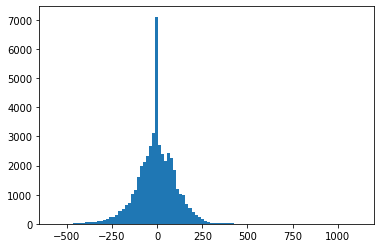

In [28]:
plt.hist(targets, bins=100);

In [29]:
mid_prices = [book.mid_price() for book in books]

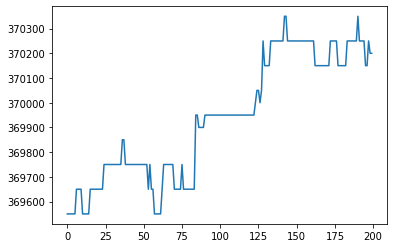

In [30]:
plt.plot(mid_prices[800:1000])

In [31]:
features_per_day, targets_per_day = get_features_and_targets(message_per_day, orderbook_per_day)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [256]:
GENERATED_DATASET_PATH = '/home/ayagudin/dl/probabilistic-time-series/lobster_dataset/'

dump_features_and_targets(GENERATED_DATASET_PATH, features_per_day, targets_per_day)

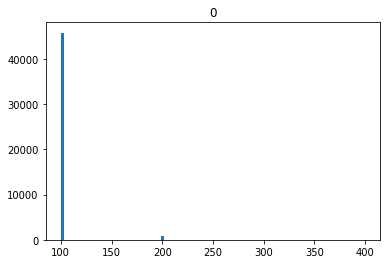

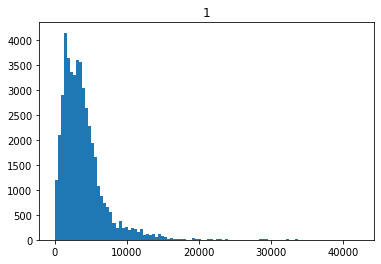

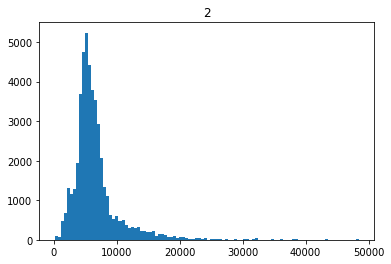

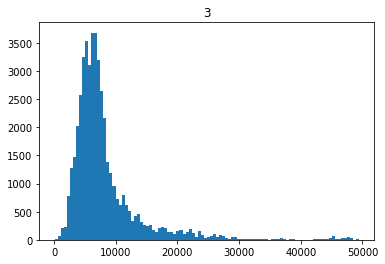

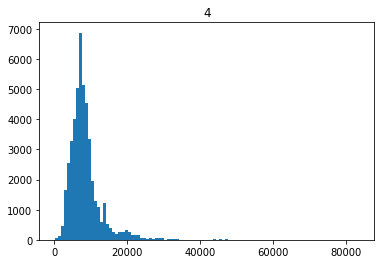

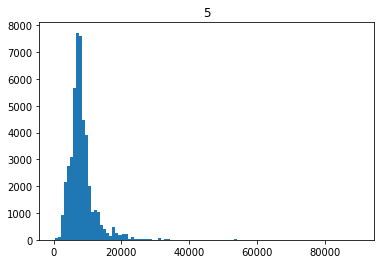

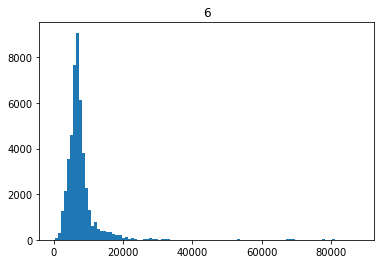

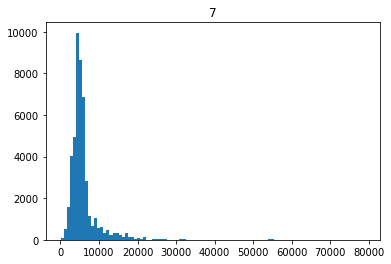

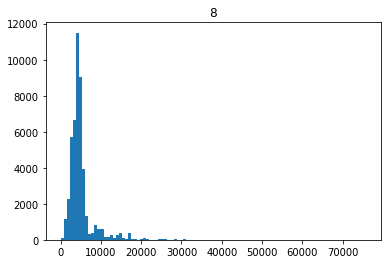

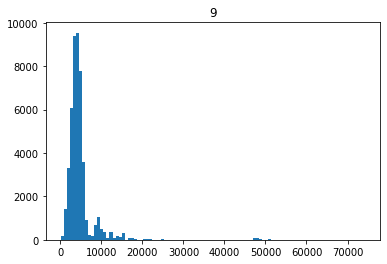

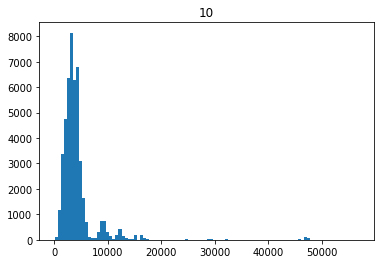

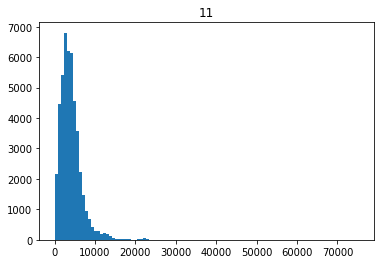

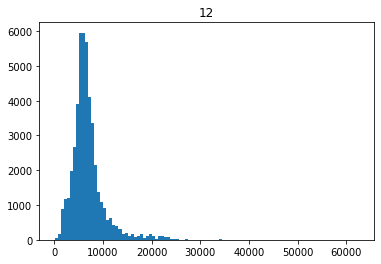

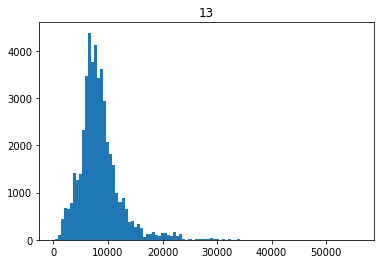

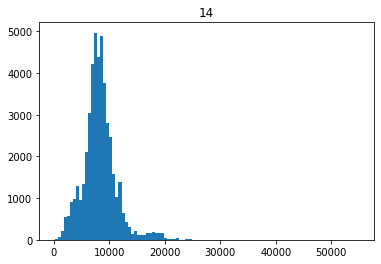

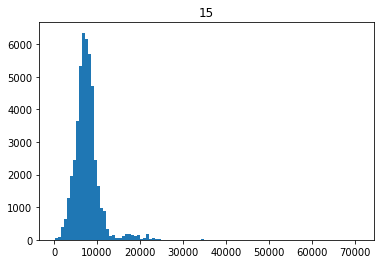

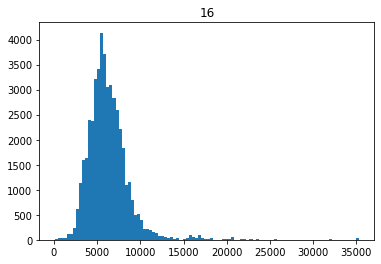

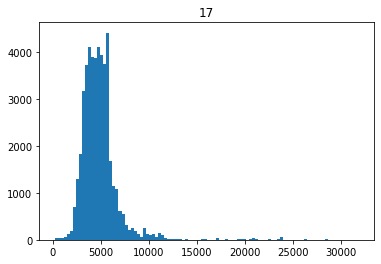

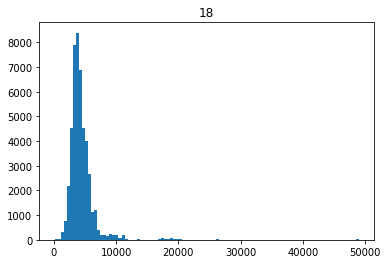

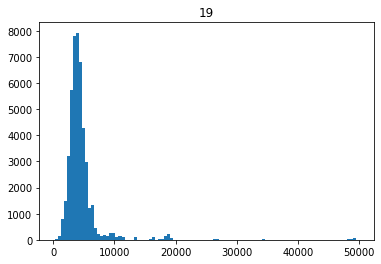

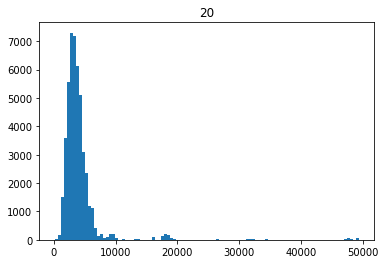

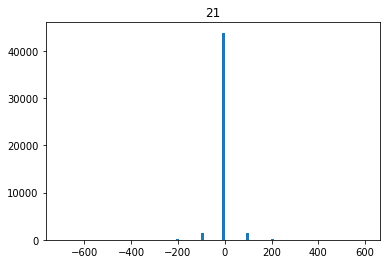

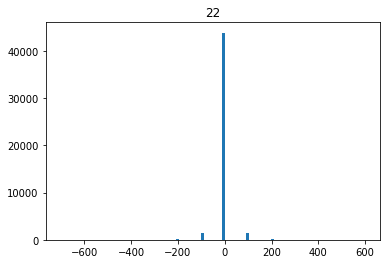

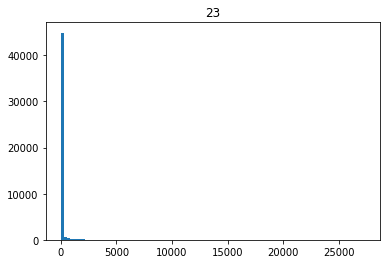

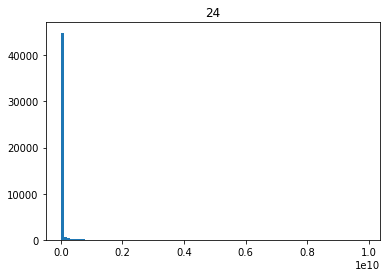

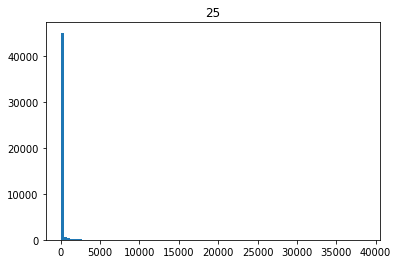

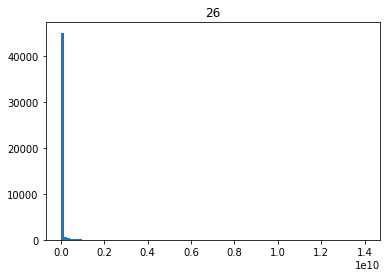

In [264]:
for i in range(27):
    plt.hist(features_per_day['2015-01-20'][:, i], bins=100)
    plt.title(i)
    plt.show()

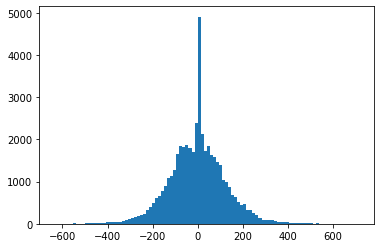

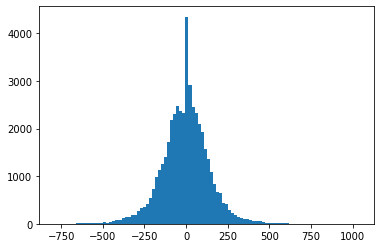

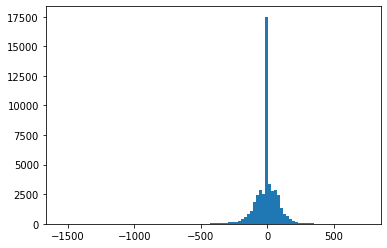

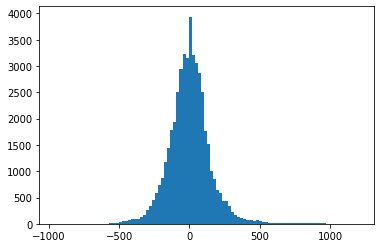

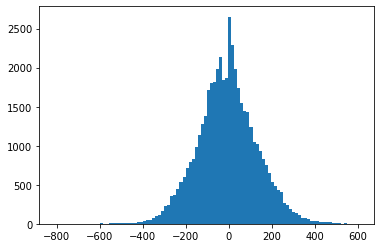

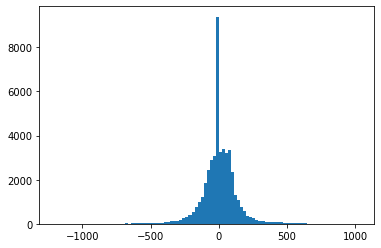

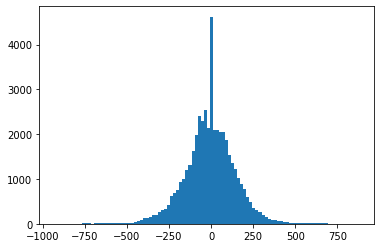

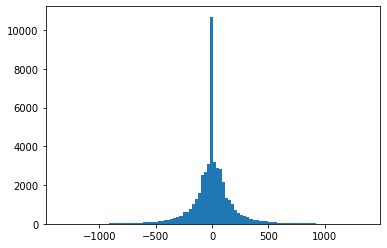

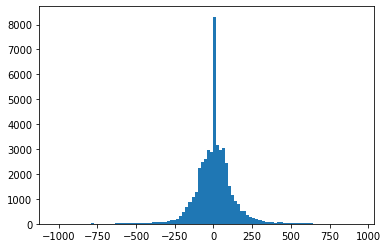

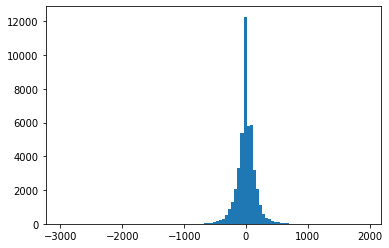

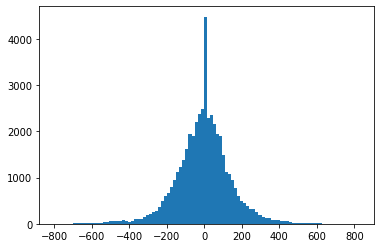

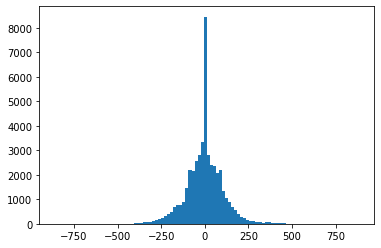

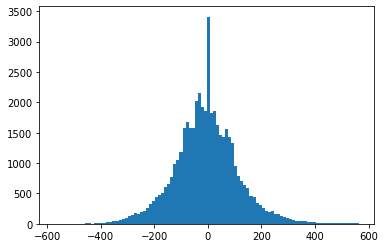

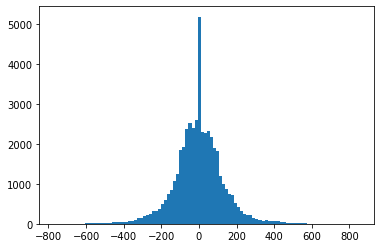

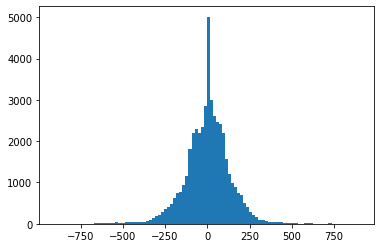

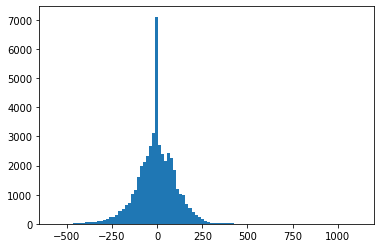

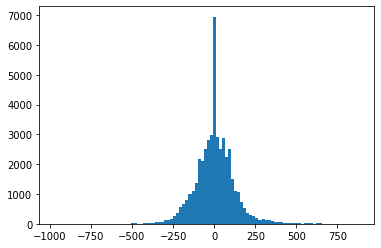

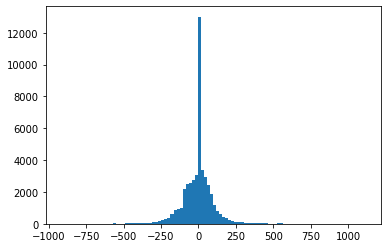

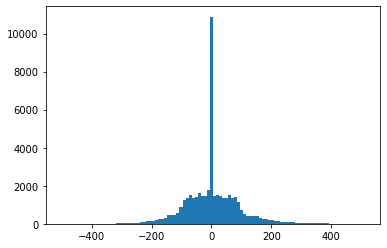

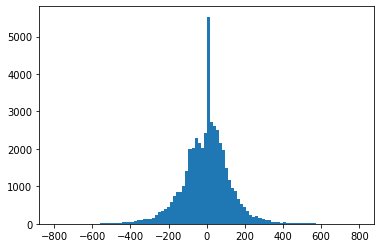

In [257]:
for day in features_per_day:
    plt.hist(targets_per_day[day], bins=100)
    plt.show()

In [40]:
no_trades = (np.array(trade_amounts['bid']) == 0) & (np.array(trade_amounts['ask']) == 0) 

In [44]:
no_trades.shape

(46798,)

In [49]:
(np.array(mid_prices[1:]) - np.array(mid_prices[:-1]) == 0).mean()

0.9485223411757164

In [59]:
(message_per_day['2015-01-02'][1] == 4).mean()

0.0232495783711438